# Visualización del Impacto del Apagón de Internet en España en el Número de Commits Diarios de GitHub

Este notebook analiza visualmente el impacto del apagón de internet en España (28 de abril de 2025) en la actividad de desarrolladores de software usando datos de GitHub. Compararemos la actividad de programadores en España con países de control (Francia e Inglaterra) que no experimentaron interrupciones durante el mismo periodo.


## 1. Configuración e Importación


In [1]:
import json
from collections import defaultdict
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os

# Variable global para la ruta de datos (ajústala según tu estructura de directorio)
data_dir = "data"


In [3]:
def load_and_process_data(json_file, window_size=7):
    """Carga y procesa los datos de un archivo JSON, sin eliminar ningún dato."""
    try:
        # Cargar datos
        with open(json_file, 'r') as f:
            data = json.load(f)

        # Diccionarios para almacenar datos procesados
        commits_by_day = defaultdict(int)
        active_users_by_day = defaultdict(set)

        # Procesar los datos de cada usuario, sin filtrar ningún período
        for user_id, stats in data.items():
            for fecha_str, cnt in stats.get("daily_commits", {}).items():
                current_date_obj = dt.datetime.strptime(fecha_str, "%Y-%m-%d")

                # Acumular datos sin filtrar
                commits_by_day[fecha_str] += cnt
                if cnt > 0:
                    active_users_by_day[fecha_str].add(user_id)

        # Ordenar fechas
        fechas = sorted(commits_by_day.keys())

        # Manejar caso de datos vacíos
        if not fechas:
            return {
                'fechas': [],
                'commits_rolling_avg': [],
                'users_rolling_avg': [],
                'raw_commits': [],  # Añadimos datos crudos
                'raw_users': []
            }

        # Convertir fechas a objetos datetime
        fechas_dt = [dt.datetime.strptime(f, "%Y-%m-%d") for f in fechas]
        counts = [commits_by_day[f] for f in fechas]
        active_users = [len(active_users_by_day[f]) for f in fechas]

        # Crear serie temporal completa con fechas faltantes
        if len(fechas_dt) > 1:
            # Determinar rango de fechas
            current_date_fill = fechas_dt[0]
            end_date_fill = fechas_dt[-1]

            # Generar todas las fechas en el rango
            date_range = []
            while current_date_fill <= end_date_fill:
                date_range.append(current_date_fill)
                current_date_fill += dt.timedelta(days=1)

            # Completar series con valores para todas las fechas
            complete_counts = []
            complete_users = []
            complete_dates = []

            for date_in_range in date_range:
                date_str = date_in_range.strftime("%Y-%m-%d")
                complete_dates.append(date_in_range)

                # Asignar valor real o cero según exista datos
                if date_str in commits_by_day:
                    complete_counts.append(commits_by_day[date_str])
                    complete_users.append(len(active_users_by_day[date_str]))
                else:
                    complete_counts.append(0)
                    complete_users.append(0)

            # Reemplazar series originales con series completas
            fechas_dt = complete_dates
            counts = complete_counts
            active_users = complete_users
        elif not fechas_dt:
             counts = []
             active_users = []

        # Calcular promedios móviles
        commits_rolling_avg = calculate_rolling_average(counts, window_size)
        users_rolling_avg = calculate_rolling_average(active_users, window_size)

        return {
            'fechas': fechas_dt,
            'commits_rolling_avg': commits_rolling_avg,
            'users_rolling_avg': users_rolling_avg,
            'raw_commits': counts,  # Datos sin promediar
            'raw_users': active_users
        }
    except Exception as e:
        print(f"Error procesando {json_file}: {e}")
        return {
            'fechas': [],
            'commits_rolling_avg': [],
            'users_rolling_avg': [],
            'raw_commits': [],
            'raw_users': []
        }

In [4]:
def plot_daily_activity(
    countries=["Spain", "France", "England"],
    highlight_start="2025-04-01",
    highlight_end="2025-04-30",
    window_size=7,
    output_dir="output",
    show_highlight=True  # Nuevo parámetro para mostrar/ocultar área sombreada
):
    """Genera gráficas de actividad diaria (commits y usuarios) a escala real para individuales."""
    # Asegurar que existe el directorio de salida
    os.makedirs(output_dir, exist_ok=True)

    # Diccionarios para almacenar datos procesados y estadísticas
    all_data = {}
    max_commits_overall_comparative = 0
    max_users_overall_comparative = 0

    # Colores para cada país
    colors = {"Spain": "red", "France": "blue", "England": "purple"}

    # Convertir fechas de interés a objetos datetime
    hl_start_dt = dt.datetime.strptime(highlight_start, "%Y-%m-%d")
    hl_end_dt = dt.datetime.strptime(highlight_end, "%Y-%m-%d")

    # Cargar y procesar datos para cada país
    for country in countries:
        json_file = os.path.join(data_dir, f"{country}_data.json")
        try:
            country_data = load_and_process_data(json_file, window_size)
            all_data[country] = country_data

            # Actualizar máximos para escala común en gráficos comparativos
            if country_data['commits_rolling_avg']:
                current_max_commits = max(country_data['commits_rolling_avg'])
                max_commits_overall_comparative = max(max_commits_overall_comparative, current_max_commits)

            if country_data['users_rolling_avg']:
                current_max_users = max(country_data['users_rolling_avg'])
                max_users_overall_comparative = max(max_users_overall_comparative, current_max_users)

        except FileNotFoundError:
            print(f"Advertencia: Archivo {json_file} no encontrado.")
            all_data[country] = {'fechas': [], 'commits_rolling_avg': [], 'users_rolling_avg': []}

    # Generar gráficas individuales de commits diarios
    create_individual_plots(
        all_data,
        colors,
        hl_start_dt,
        hl_end_dt,
        'commits_rolling_avg',
        'Commits diarios a GitHub',
        'Número de Commits (promedio)',
        'commits_diarios',
        output_dir,
        show_highlight
    )

    # Generar gráfica comparativa de commits diarios
    create_comparative_plot(
        all_data,
        colors,
        hl_start_dt,
        hl_end_dt,
        'commits_rolling_avg',
        'Comparación de commits diarios a GitHub',
        'Número de commits (promedio)',
        max_commits_overall_comparative,
        'comparacion_commits_diarios',
        output_dir,
        show_highlight
    )


## 2. Configuración de gráficos


In [5]:
def plot_daily_raw_activity(
    countries=["Spain", "France", "England"],
    highlight_start="2025-04-01",
    highlight_end="2025-04-30",
    output_dir="output",
    show_highlight=True
):
    """Genera gráficas de actividad diaria usando datos sin promediar."""
    # Asegurar que existe el directorio de salida
    os.makedirs(output_dir, exist_ok=True)

    # Diccionarios para almacenar datos procesados y estadísticas
    all_data = {}
    max_commits_overall = 0
    max_users_overall = 0

    # Colores para cada país
    colors = {"Spain": "red", "France": "blue", "England": "purple"}

    # Convertir fechas de interés a objetos datetime
    hl_start_dt = dt.datetime.strptime(highlight_start, "%Y-%m-%d")
    hl_end_dt = dt.datetime.strptime(highlight_end, "%Y-%m-%d")

    # Cargar y procesar datos para cada país
    for country in countries:
        json_file = os.path.join(data_dir, f"{country}_data.json")
        try:
            country_data = load_and_process_data(json_file)

            # Actualizar máximos para escala común en gráficos comparativos
            if country_data['raw_commits']:
                current_max = max(country_data['raw_commits'])
                max_commits_overall = max(max_commits_overall, current_max)

            if country_data['raw_users']:
                current_max = max(country_data['raw_users'])
                max_users_overall = max(max_users_overall, current_max)

            all_data[country] = country_data
        except FileNotFoundError:
            print(f"Advertencia: Archivo {json_file} no encontrado.")
            all_data[country] = {'fechas': [], 'raw_commits': [], 'raw_users': []}

    # Generar gráficas individuales de commits diarios (RAW)
    for country, data_dict in all_data.items():
        if not data_dict['fechas'] or not data_dict['raw_commits']:
            print(f"No hay datos de commits para graficar de {country}.")
            continue

        fig, ax = plt.subplots(figsize=(12, 6))

        # Graficar datos crudos como puntos y línea
        ax.plot(data_dict['fechas'], data_dict['raw_commits'],
               marker='o', markersize=3, linestyle='-', linewidth=1,
               color=colors.get(country, 'blue'), label='Commits diarios')

        # Opcionalmente destacar período de apagón
        if show_highlight:
            ax.axvspan(hl_start_dt, hl_end_dt, alpha=0.2, color='yellow', label='Período de apagón')
            # Agregar líneas verticales para marcar claramente el inicio y fin del período
            ax.axvline(x=hl_start_dt, color='red', linestyle='--', alpha=0.7, label='Inicio apagón')
            ax.axvline(x=hl_end_dt, color='red', linestyle='--', alpha=0.7, label='Fin apagón')

        # Configurar escala local para el eje Y
        local_max_value = max(data_dict['raw_commits']) if data_dict['raw_commits'] else 0
        ax.set_ylim(bottom=0, top=local_max_value * 1.1 if local_max_value > 0 else 1)

        # Configurar ejes y etiquetas
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
        plt.xticks(rotation=45, ha='right')

        # Títulos y leyenda
        ax.set_title(f'Commits diarios (datos crudos) - {country}')
        ax.set_xlabel('Fecha')
        ax.set_ylabel('Número de Commits')
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.legend()

        # Ajustar diseño y guardar
        plt.tight_layout()
        output_file = os.path.join(output_dir, f"{country}_commits_raw.png")
        plt.savefig(output_file, dpi=300)
        plt.close(fig)
        print(f"Figura guardada como: {output_file}")

    # Generar gráfica comparativa de commits diarios (RAW)
    fig, ax = plt.subplots(figsize=(14, 7))
    has_data = False

    for country, data_dict in all_data.items():
        if data_dict['fechas'] and data_dict['raw_commits']:
            ax.plot(data_dict['fechas'], data_dict['raw_commits'],
                   marker='o', markersize=2, linestyle='-', linewidth=1,
                   color=colors.get(country, 'blue'), label=country)
            has_data = True

    if has_data:
        # Opcionalmente destacar período de apagón
        if show_highlight:
            ax.axvspan(hl_start_dt, hl_end_dt, alpha=0.2, color='yellow', label='Período de apagón')
            ax.axvline(x=hl_start_dt, color='red', linestyle='--', alpha=0.7, label='Inicio apagón')
            ax.axvline(x=hl_end_dt, color='red', linestyle='--', alpha=0.7, label='Fin apagón')

        # Configurar escala para el eje Y
        ax.set_ylim(bottom=0, top=max_commits_overall * 1.1 if max_commits_overall > 0 else 1)

        # Configurar ejes y etiquetas
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
        plt.xticks(rotation=45, ha='right')

        # Títulos y leyenda
        ax.set_title('Comparación de commits diarios (datos crudos)')
        ax.set_xlabel('Fecha')
        ax.set_ylabel('Número de commits')
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.legend()

        # Ajustar diseño y guardar
        plt.tight_layout()
        output_file = os.path.join(output_dir, "comparacion_commits_raw.png")
        plt.savefig(output_file, dpi=300)
        print(f"Figura comparativa guardada como: {output_file}")
    else:
        print("No hay datos para la gráfica comparativa después del filtrado.")

    plt.close(fig)

In [6]:
def plot_percentage_change(
    countries=["Spain", "France", "England"],
    highlight_start="2025-04-01",
    highlight_end="2025-04-30",
    window_size=7,
    show_highlight=True,
    output_dir="output"
):
    """Genera gráficas de cambio porcentual en actividad diaria."""
    os.makedirs(output_dir, exist_ok=True)

    all_data = {}
    min_pct_change = 0
    max_pct_change = 0

    colors = {"Spain": "red", "France": "blue", "England": "purple"}

    hl_start_dt = dt.datetime.strptime(highlight_start, "%Y-%m-%d")
    hl_end_dt = dt.datetime.strptime(highlight_end, "%Y-%m-%d")

    # Cargar y procesar datos para cada país
    for country in countries:
        json_file = os.path.join(data_dir, f"{country}_data.json")
        try:
            country_data = load_and_process_data(json_file, window_size)

            if not country_data['fechas'] or not country_data['commits_rolling_avg']:
                print(f"No hay suficientes datos para {country} después del filtrado.")
                all_data[country] = {'fechas': [], 'pct_change': []}
                continue

            # Calcular cambio porcentual día a día
            pct_change = []
            fechas_pct = []

            for i in range(1, len(country_data['commits_rolling_avg'])):
                today = country_data['commits_rolling_avg'][i]
                yesterday = country_data['commits_rolling_avg'][i-1]

                if yesterday != 0:  # Evitar división por cero
                    change = ((today - yesterday) / yesterday) * 100
                else:
                    if today == 0:
                        change = 0
                    else:
                        change = 100  # Si ayer fue 0 y hoy no, consideramos un 100% de aumento

                pct_change.append(change)
                fechas_pct.append(country_data['fechas'][i])

            all_data[country] = {
                'fechas': fechas_pct,
                'pct_change': pct_change
            }

            # Actualizar límites globales
            if pct_change:
                current_min = min(pct_change)
                current_max = max(pct_change)
                min_pct_change = min(min_pct_change, current_min)
                max_pct_change = max(max_pct_change, current_max)

        except FileNotFoundError:
            print(f"Advertencia: Archivo {json_file} no encontrado.")
            all_data[country] = {'fechas': [], 'pct_change': []}

    # Generar gráficas individuales de cambio porcentual
    for country, data_dict in all_data.items():
        if not data_dict['fechas'] or not data_dict['pct_change']:
            continue

        fig, ax = plt.subplots(figsize=(12, 6))

        # Graficar cambio porcentual
        ax.plot(
            data_dict['fechas'],
            data_dict['pct_change'],
            linestyle='-',
            linewidth=2.0,
            color=colors.get(country, 'blue'),
            label='Cambio porcentual diario'
        )

        # Agregar línea horizontal en 0% para referencia
        ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)

        # Opcionalmente destacar período de apagón
        if show_highlight:
            ax.axvspan(hl_start_dt, hl_end_dt, alpha=0.2, color='yellow', label='Período de apagón')
            ax.axvline(x=hl_start_dt, color='red', linestyle='--', alpha=0.7, label='Inicio apagón')
            ax.axvline(x=hl_end_dt, color='red', linestyle='--', alpha=0.7, label='Fin apagón')

        # Configurar límites del eje Y con margen
        buffer = 10  # Porcentaje adicional de margen
        y_min = min(data_dict['pct_change']) - buffer
        y_max = max(data_dict['pct_change']) + buffer
        ax.set_ylim(bottom=y_min, top=y_max)

        # Configurar ejes y etiquetas
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
        plt.xticks(rotation=45, ha='right')

        # Títulos y leyenda
        ax.set_title(f'Cambio porcentual diario en commits - {country}')
        ax.set_xlabel('Fecha')
        ax.set_ylabel('Cambio porcentual (%)')
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.legend()

        # Ajustar diseño y guardar
        plt.tight_layout()
        output_file = os.path.join(output_dir, f"{country}_cambio_porcentual.png")
        plt.savefig(output_file, dpi=300)
        plt.close(fig)
        print(f"Figura guardada como: {output_file}")

    # Generar gráfica comparativa de cambio porcentual
    fig, ax = plt.subplots(figsize=(14, 7))
    has_data = False

    for country, data_dict in all_data.items():
        if data_dict['fechas'] and data_dict['pct_change']:
            ax.plot(
                data_dict['fechas'],
                data_dict['pct_change'],
                linestyle='-',
                linewidth=2.0,
                color=colors.get(country, 'blue'),
                label=country
            )
            has_data = True

    if has_data:
        # Agregar línea horizontal en 0% para referencia
        ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)

        # Opcionalmente destacar período de apagón
        if show_highlight:
            ax.axvspan(hl_start_dt, hl_end_dt, alpha=0.2, color='yellow', label='Período de apagón')
            ax.axvline(x=hl_start_dt, color='red', linestyle='--', alpha=0.7, label='Inicio apagón')
            ax.axvline(x=hl_end_dt, color='red', linestyle='--', alpha=0.7, label='Fin apagón')

        # Configurar límites del eje Y con margen
        buffer = 10  # Porcentaje adicional de margen
        ax.set_ylim(bottom=min_pct_change-buffer, top=max_pct_change+buffer)

        # Configurar ejes y etiquetas
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
        plt.xticks(rotation=45, ha='right')

        # Títulos y leyenda
        ax.set_title('Comparación de cambio porcentual diario en commits')
        ax.set_xlabel('Fecha')
        ax.set_ylabel('Cambio porcentual (%)')
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.legend()

        # Ajustar diseño y guardar
        plt.tight_layout()
        output_file = os.path.join(output_dir, "comparacion_cambio_porcentual.png")
        plt.savefig(output_file, dpi=300)
        print(f"Figura comparativa guardada como: {output_file}")
    else:
        print("No hay datos para la gráfica comparativa de cambio porcentual.")

    plt.close(fig)

In [7]:
def create_individual_plots(all_data, colors, hl_start_dt, hl_end_dt, data_key, title_prefix, ylabel, filename_suffix, output_dir, show_highlight=True):
    """Función auxiliar para crear gráficas individuales por país"""
    for country, data_dict in all_data.items():
        if not data_dict['fechas'] or not data_dict[data_key]:
            print(f"No hay datos de {data_key} para graficar de {country} después del filtrado.")
            continue

        fig, ax = plt.subplots(figsize=(12, 6))

        # Graficar serie temporal
        ax.plot(
            data_dict['fechas'],
            data_dict[data_key],
            linestyle='-',
            linewidth=2.5,
            color=colors.get(country, 'blue'),
            label=f'Promedio móvil (7 días)'
        )

        # Opcionalmente destacar período de apagón
        if show_highlight:
            ax.axvspan(hl_start_dt, hl_end_dt, alpha=0.2, color='yellow', label='Período de apagón')
            # Agregar líneas verticales para marcar claramente el inicio y fin del período
            ax.axvline(x=hl_start_dt, color='red', linestyle='--', alpha=0.7, label='Inicio apagón')
            ax.axvline(x=hl_end_dt, color='red', linestyle='--', alpha=0.7, label='Fin apagón')

        # Configurar escala local para el eje Y
        local_max_value = max(data_dict[data_key]) if data_dict[data_key] else 0
        ax.set_ylim(bottom=0, top=local_max_value * 1.1 if local_max_value > 0 else 1)

        # Configurar ejes y etiquetas
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
        plt.xticks(rotation=45, ha='right')

        # Títulos y leyenda
        ax.set_title(f'{title_prefix} - {country}')
        ax.set_xlabel('Fecha')
        ax.set_ylabel(ylabel)
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.legend()

        # Ajustar diseño y guardar
        plt.tight_layout()
        output_file = os.path.join(output_dir, f"{country}_{filename_suffix}.png")
        plt.savefig(output_file, dpi=300)
        plt.close(fig)
        print(f"Figura guardada como: {output_file}")

def create_comparative_plot(all_data, colors, hl_start_dt, hl_end_dt, data_key, title, ylabel, max_value, filename, output_dir, show_highlight=True):
    """Función auxiliar para crear gráficas comparativas"""
    fig, ax = plt.subplots(figsize=(14, 7))
    has_data = False

    # Graficar series de todos los países
    for country, data_dict in all_data.items():
        if data_dict['fechas'] and data_dict[data_key]:
            ax.plot(
                data_dict['fechas'],
                data_dict[data_key],
                linestyle='-',
                linewidth=2.5,
                color=colors.get(country, 'blue'),
                label=country
            )
            has_data = True

    if has_data:
        # Opcionalmente destacar período de apagón
        if show_highlight:
            ax.axvspan(hl_start_dt, hl_end_dt, alpha=0.2, color='yellow', label='Período de apagón')
            ax.axvline(x=hl_start_dt, color='red', linestyle='--', alpha=0.7, label='Inicio apagón')
            ax.axvline(x=hl_end_dt, color='red', linestyle='--', alpha=0.7, label='Fin apagón')

        # Configurar escala para el eje Y
        ax.set_ylim(bottom=0, top=max_value * 1.1 if max_value > 0 else 1)

        # Configurar ejes y etiquetas
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
        plt.xticks(rotation=45, ha='right')

        # Títulos y leyenda
        ax.set_title(title)
        ax.set_xlabel('Fecha')
        ax.set_ylabel(ylabel)
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.legend()

        # Ajustar diseño y guardar
        plt.tight_layout()
        output_file = os.path.join(output_dir, f"{filename}.png")
        plt.savefig(output_file, dpi=300)
        print(f"Figura comparativa guardada como: {output_file}")
    else:
        print(f"No hay datos para la gráfica comparativa {filename} después del filtrado.")

    plt.close(fig)


## 3. Guardando los gráficos

In [8]:
# Contenido que se ejecuta si este archivo se ejecuta directamente
if __name__ == "__main__":
    # Configuración
    countries_list = ["Spain", "France", "England"]

    # Período de "apagón" a destacar en las gráficas
    highlight_start_date = "2025-04-28"
    highlight_end_date = "2025-04-29"
    highlight_week_start_label = "2025-W14"  # Semana que incluye el 17 de julio
    highlight_week_end_label = "2025-W20"    # Semana que incluye el 24 de julio

    output_plots_dir = "output_modified" # Cambiado para no sobrescribir originales si se corre en el mismo lugar

    # Crear directorio de salida
    os.makedirs(output_plots_dir, exist_ok=True)

    # Generar diferentes visualizaciones
    print("Generando gráficas de actividad diaria (datos crudos)...")
    plot_daily_raw_activity(
        countries=countries_list,
        highlight_start=highlight_start_date,
        highlight_end=highlight_end_date,
        output_dir=output_plots_dir
    )


    print("\nGenerando gráficas de cambio porcentual...")
    plot_percentage_change(
        countries=countries_list,
        highlight_start=highlight_start_date,
        highlight_end=highlight_end_date,
        window_size=7,
        output_dir=output_plots_dir
    )

    print("\nTodas las gráficas han sido generadas correctamente.")

Generando gráficas de actividad diaria (datos crudos)...
Error procesando data\Spain_data.json: name 'calculate_rolling_average' is not defined
Error procesando data\France_data.json: name 'calculate_rolling_average' is not defined
Error procesando data\England_data.json: name 'calculate_rolling_average' is not defined
No hay datos de commits para graficar de Spain.
No hay datos de commits para graficar de France.
No hay datos de commits para graficar de England.
No hay datos para la gráfica comparativa después del filtrado.

Generando gráficas de cambio porcentual...
Error procesando data\Spain_data.json: name 'calculate_rolling_average' is not defined
No hay suficientes datos para Spain después del filtrado.
Error procesando data\France_data.json: name 'calculate_rolling_average' is not defined
No hay suficientes datos para France después del filtrado.
Error procesando data\England_data.json: name 'calculate_rolling_average' is not defined
No hay suficientes datos para England despué

## 4. Visualización de datos crudos diarios

Estos gráficos muestran los datos diarios sin promediar, lo que permite ver las fluctuaciones diarias reales en la actividad.

In [9]:
from IPython.display import Image, display
output_dir='output_modified'

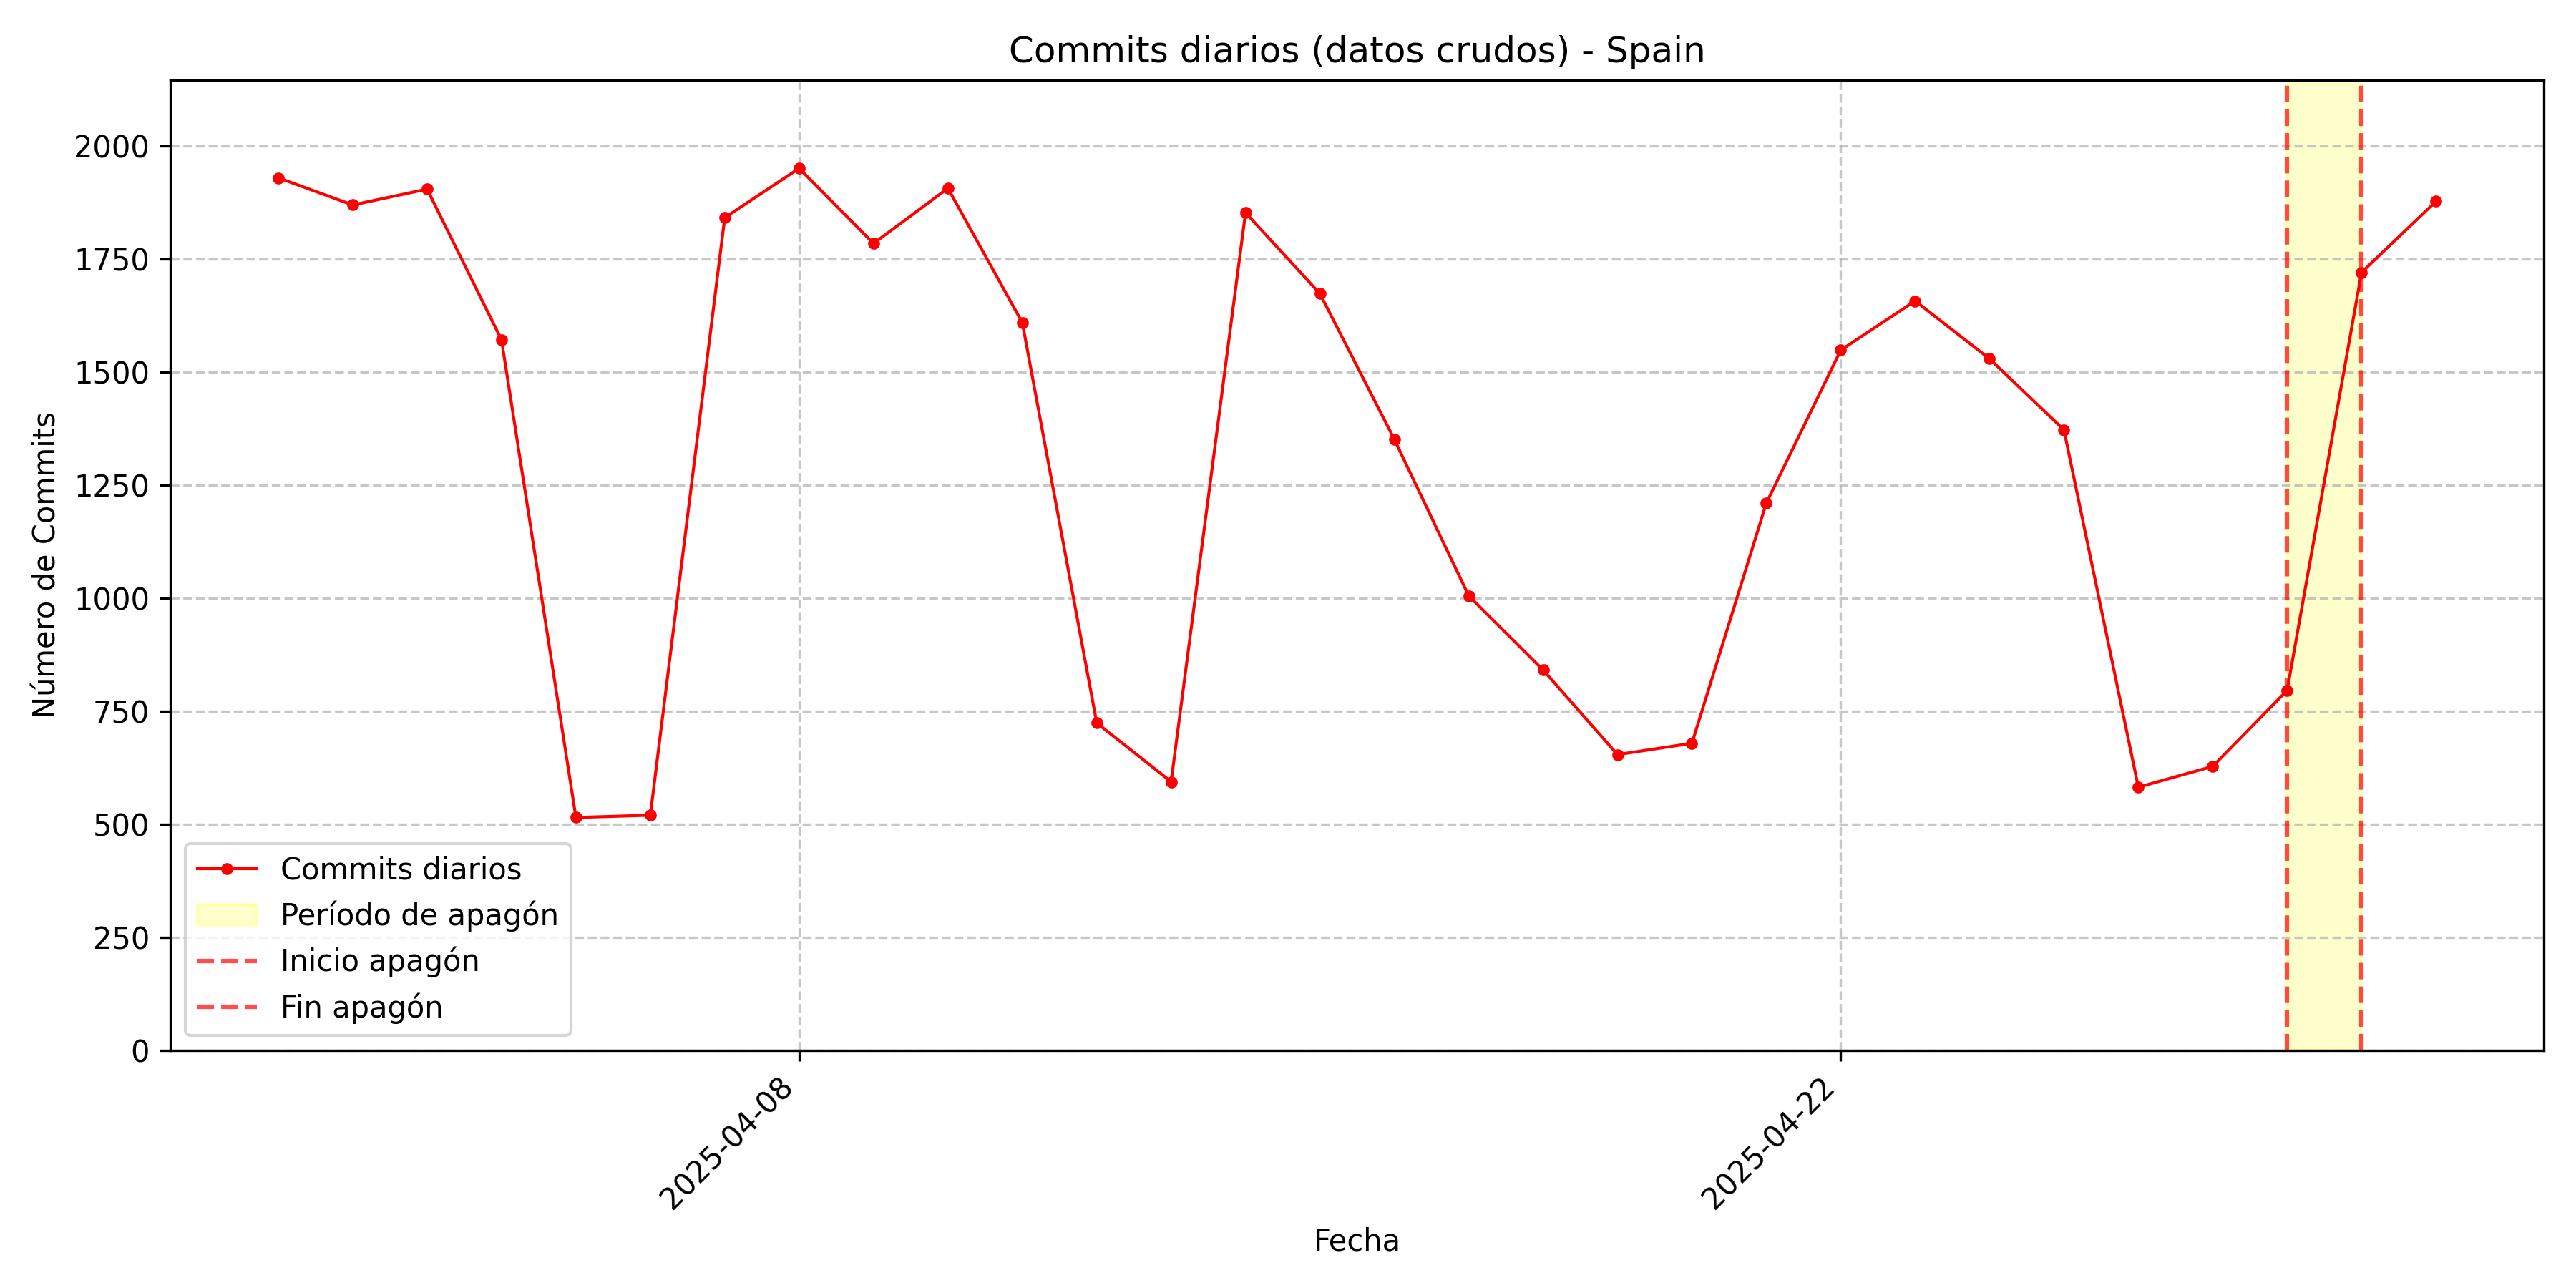

In [10]:
display(Image(filename=os.path.join(output_dir, "Spain_commits_raw.png")))

## 4. Visualización de datos en cambios porcentuales

Estos gráficos muestran la variación porcentual de commit diarios.

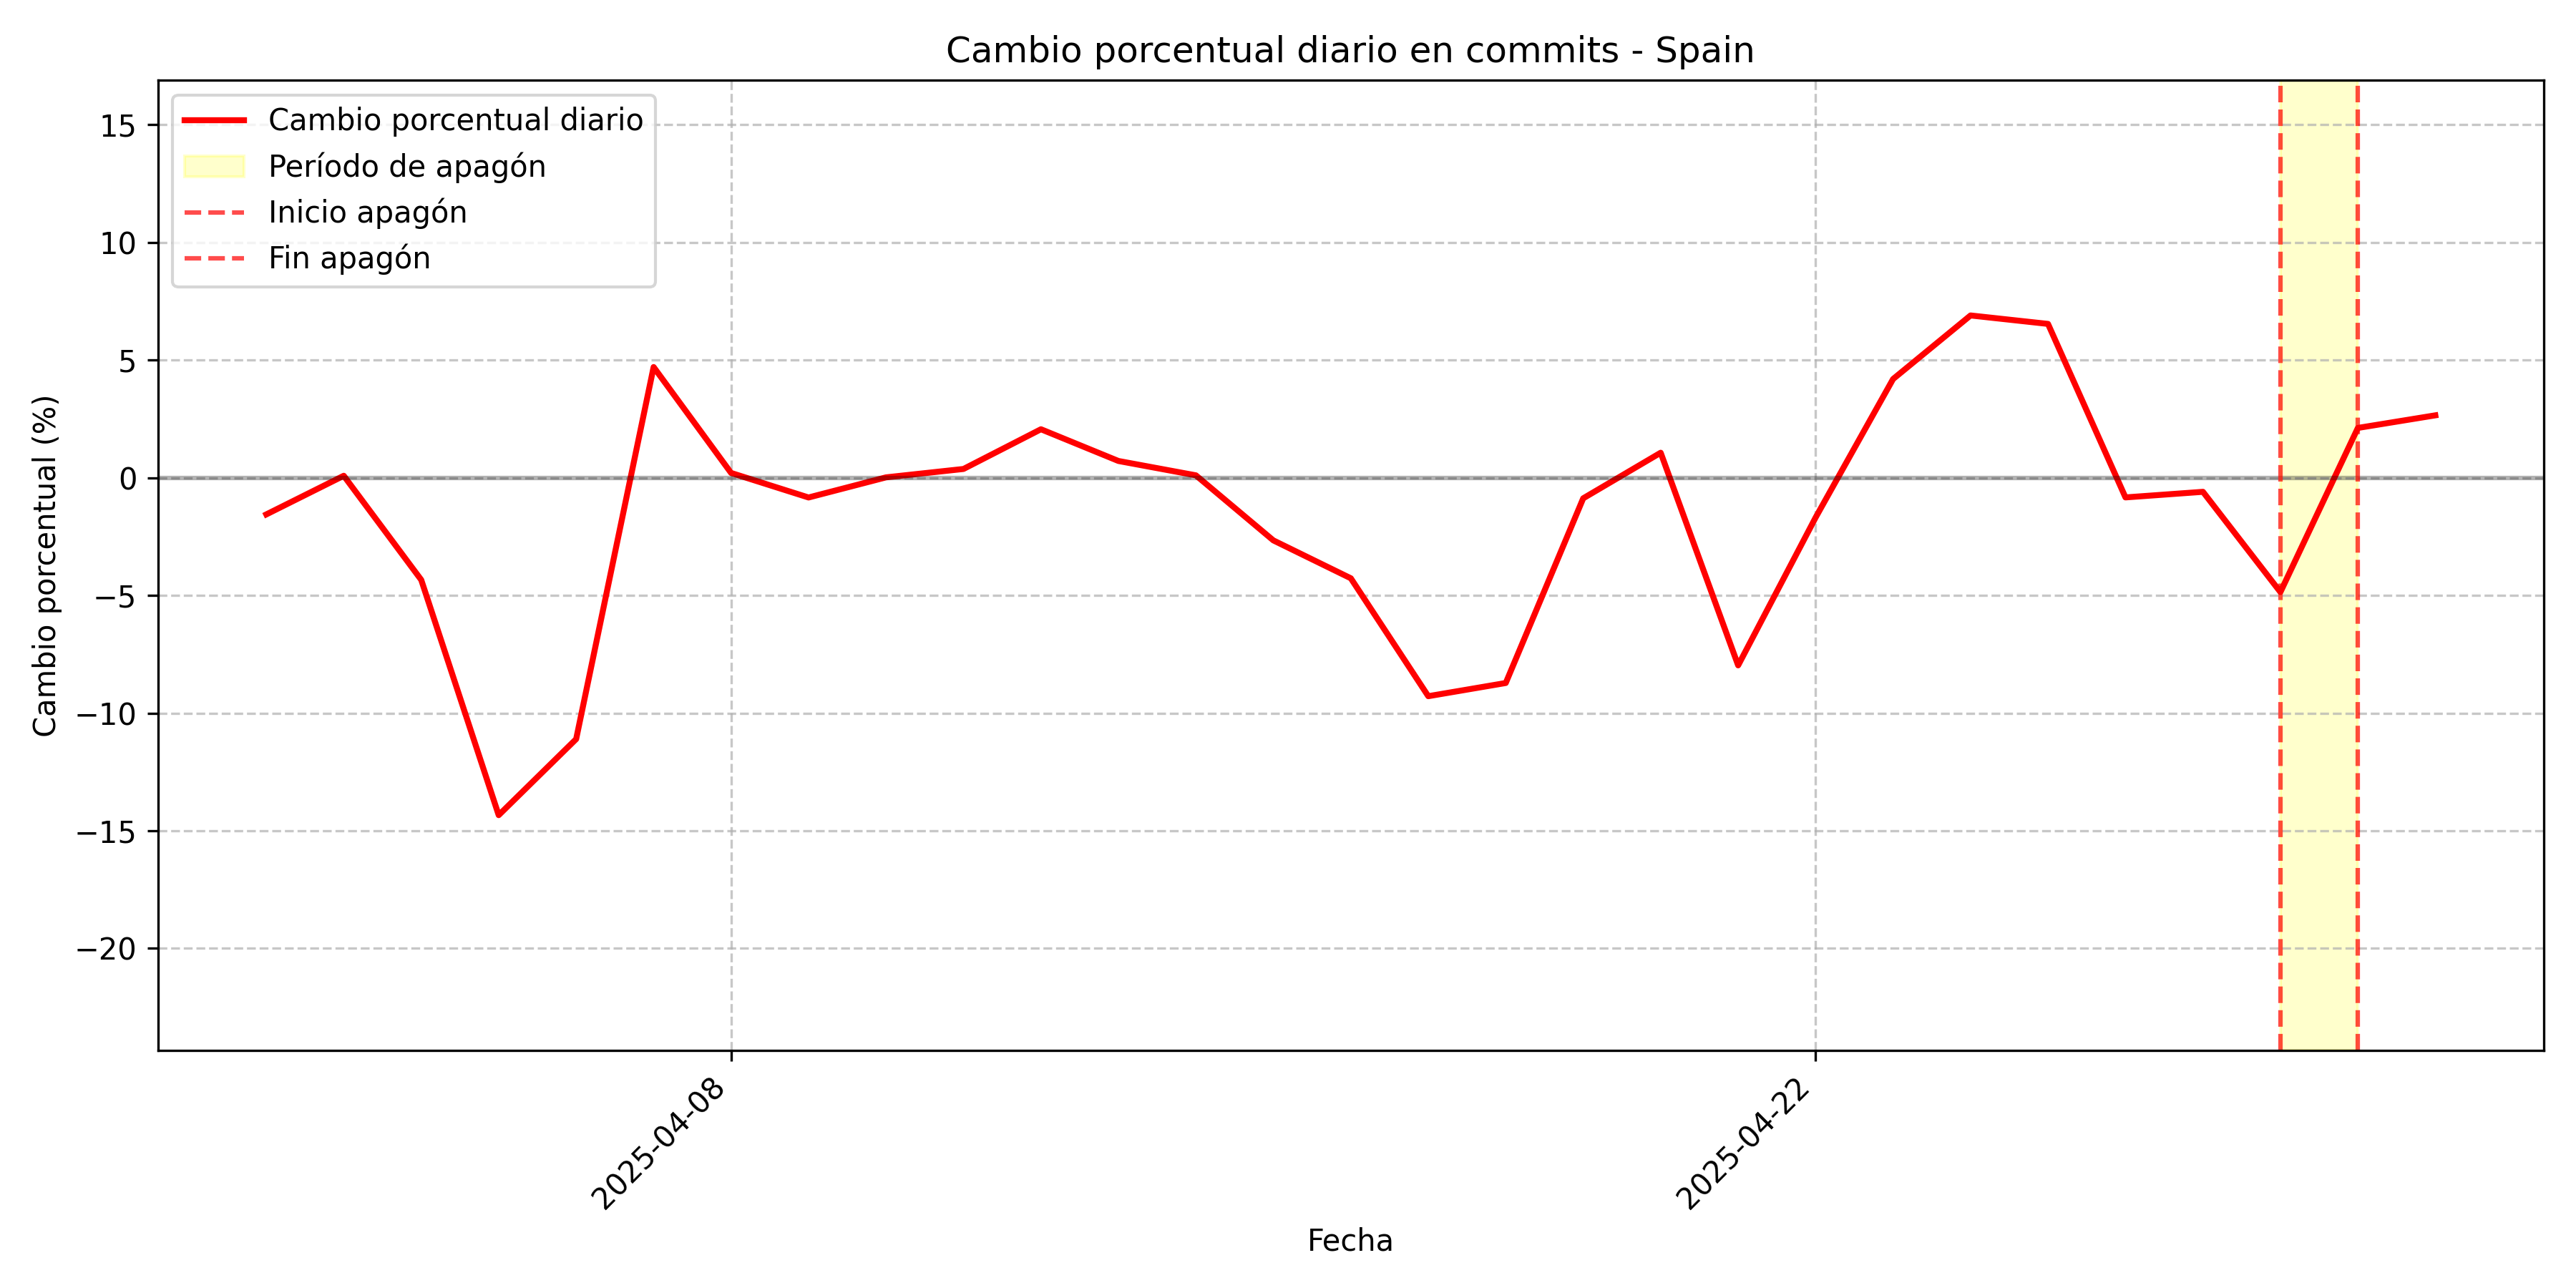

In [11]:
display(Image(filename=os.path.join(output_dir, "Spain_cambio_porcentual.png")))

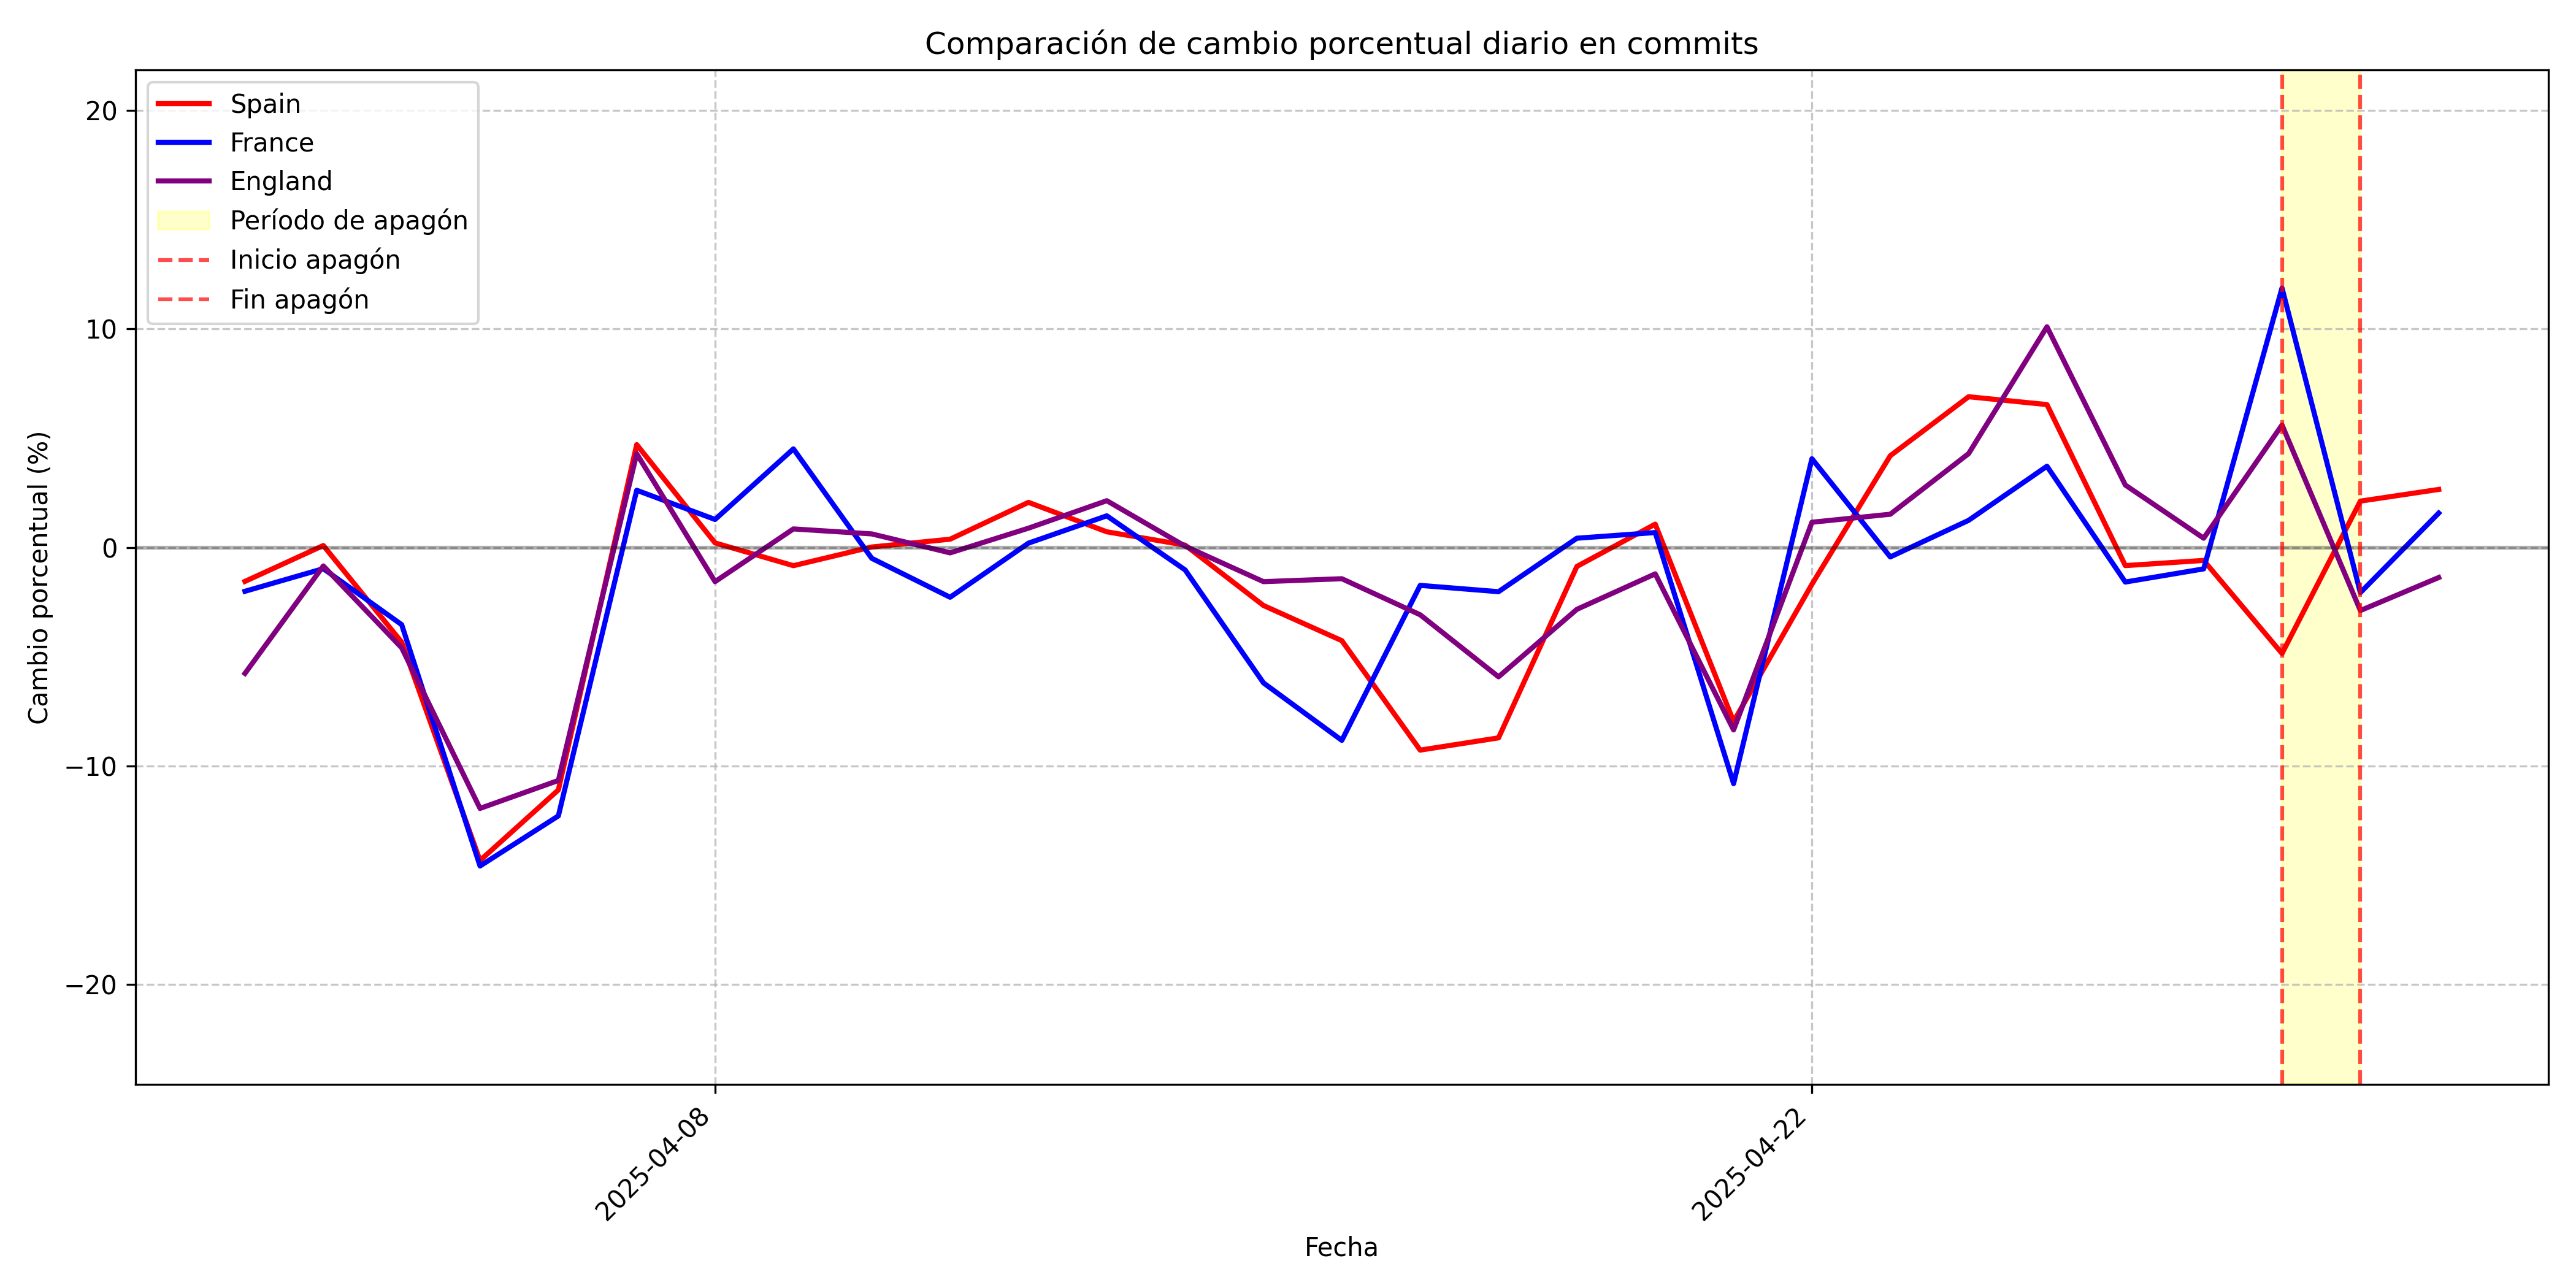

In [14]:

display(Image(filename=os.path.join(output_dir, "comparacion_cambio_porcentual.png")))

En este grafico se puede observar la comparación de las actividades de otros desarrolladores de España estaban por encima de los commits de Francia e Inglaterra, pero cuando hubo este apagón la diferencia se observa en el sombreado amarillo que España está por debajo de los país de control